# Reservoirs tables - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 06-10-2024<br>

**Introduction:**<br>

* [x] 100-year return period of inflow
* [x] average inflow
* [ ] environmental flow?
* [x] storage capacity
* [x] catchment area
* [ ] reservoir area: it would be necessary if we want to model the reservoir surface area
* [ ] elevation crest: it would be necessary if we want to model the reservoir level
* [ ] dam height: it would be necessary if we want to model the reservoir level

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
def compare_attributes(df, thr, vmin, vmax, **kwargs):
    """Pair plot comparing the attribute values in different data sources
    
    Parameters:
    -----------
    df: pandas.DataFrame
        Values of an attributes in different data sources (columns)
    thr: float
        Minimum value of the attribute used in the selection
    vmin: float
        Minimum attribute value to be plotted
    vmax: float
        Maximum attribute value to be plotted
    """
    
    figsize = kwargs.get('figsize', (4, 4))
    
    cols = df.columns
    ncols = len(cols) - 1
    
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(ncols * figsize[0], ncols * figsize[1]), sharex=True, sharey=True)

    for j, colx in enumerate(cols[:-1]):
        for i, coly in enumerate(cols[1:]):
            if j > i:
                ax[i, j].axis('off')
                continue
            ax[i, j].plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
            ax[i, j].vlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].hlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].scatter(df[colx], df[coly], s=10, alpha=.5)
            ax[i, j].set_xscale('log')
            ax[i, j].set_yscale('log')
            if j == 0:
                ax[i, j].set_ylabel(coly)
            if i == 2:
                ax[i, j].set_xlabel(colx)

            ax[i, j].set(
                xlim=(vmin, vmax),
                ylim=(vmin, vmax),
            );
    
    if 'title' in kwargs:
        ax[0, 1].set_title(kwargs['title']);

## Configuration

In [38]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_EFAS6 = PATH_DATASETS / 'reservoirs' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 50 # km²
MIN_DOR = 0.08 # 

## Data

### EFAS6
I load a shapefile with the manual selection of reservoirs to be included in EFASv6, which have already been located in the LISFLOOD grid.

In [5]:
# import shapefile
# reservoirs = gpd.read_file('Z:/H07_Global/GloFAS/data/reservoir and lakes EFAS Glofas 2024/reservoirEfasV6.shp')
efas6 = gpd.read_file(PATH_EFAS6 / 'efas6_reservoirs.shp')
efas6.GRanD_id = efas6.GRanD_id.astype('Int64')
efas6.Hylak_id = efas6.Hylak_id.astype('Int64')
efas6.ResID = efas6.ResID.astype('Int64')

In [6]:
# assing ID in descending order of storage capacity
efas6.sort_values('CAP_MCM', ascending=False, inplace=True)
efas6.reset_index(drop=True, inplace=True)
efas6.index.name = 'ID'

### EFASv5

In [7]:
efas5 = gpd.read_file(PATH_EFAS6 / 'EFAS5' / 'efas5_reservoirs.shp')#.set_index('ResID')

# assign ID
map_efas_ID = {ResID: ID for ID, ResID in zip(efas6.index, efas6.ResID) if not pd.isna(ResID)}
efas5['ID'] = efas5.ResID.map(map_efas_ID).astype('Int64')
efas5.dropna(subset=['ID'], inplace=True)
efas5.set_index('ID', drop=True, inplace=True)

print(efas5.shape)

(1393, 33)


### GRanD

In [8]:
grand = gpd.read_file(PATH_EFAS6 / 'GRanD' / 'grand_dams.shp')

# connection between GRanD_id and ID
map_grand_ID = {grand_id: ID for ID, grand_id in zip(efas6.index, efas6.GRanD_id) if not pd.isna(grand_id)}
grand['ID'] = grand.GRAND_ID.map(map_grand_ID)
grand.set_index('GRAND_ID', drop=True, inplace=True)

print(grand.shape)

(1575, 62)


### ICOLD

In [9]:
icold = gpd.read_file(PATH_EFAS6 / 'ICOLD' / 'icold.shp')#.set_index('Int_Code')

# connection between ICOLD and ID
map_icold_ID = {icold_id: ID for ID, icold_id in zip(efas6.index, efas6.ICOLD_id) if not pd.isna(icold_id)}
icold['ID'] = icold.Int_Code.map(map_icold_ID)
icold.set_index('Int_Code', drop=True, inplace=True)

print(icold.shape)

(7887, 46)


### HydroLakes

In [10]:
hylak = gpd.read_file(PATH_EFAS6 / 'HydroLakes' / 'hydrolakes_dams.shp')#.set_index('Hylak_id')

# connection between ICOLD and ID
map_hylak_ID = {hylak_id: ID for ID, hylak_id in zip(efas6.index, efas6.Hylak_id) if not pd.isna(hylak_id)}
hylak['ID'] = hylak.Hylak_id.map(map_hylak_ID)
hylak.set_index('Hylak_id', drop=True, inplace=True)

print(hylak.shape)

(1415, 307)


## Attributes
### Capacity

In [11]:
capacity = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
capacity.SOURCE = capacity.SOURCE.astype(str)

# EFAS5
capacity.loc[efas5.index, 'EFAS5'] = efas5.tstor

# GRanD
# capacity.loc[efas6.index, 'GRAND'] = efas6.CAP_MCM
mask = grand.ID.notnull()
capacity.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'CAP_MCM'].values

# ICOLD
# capacity.loc[efas5.index, 'ICOLD'] = efas5.ICOLD_VOL
mask = icold.ID.notnull()
capacity.loc[icold.loc[mask, 'ID'], 'ICOLD'] = icold.loc[mask, 'Res_Vol'].values

# HydroLakes
mask = hylak.ID.notnull()
capacity.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Vol_res'].values

#### Comparison

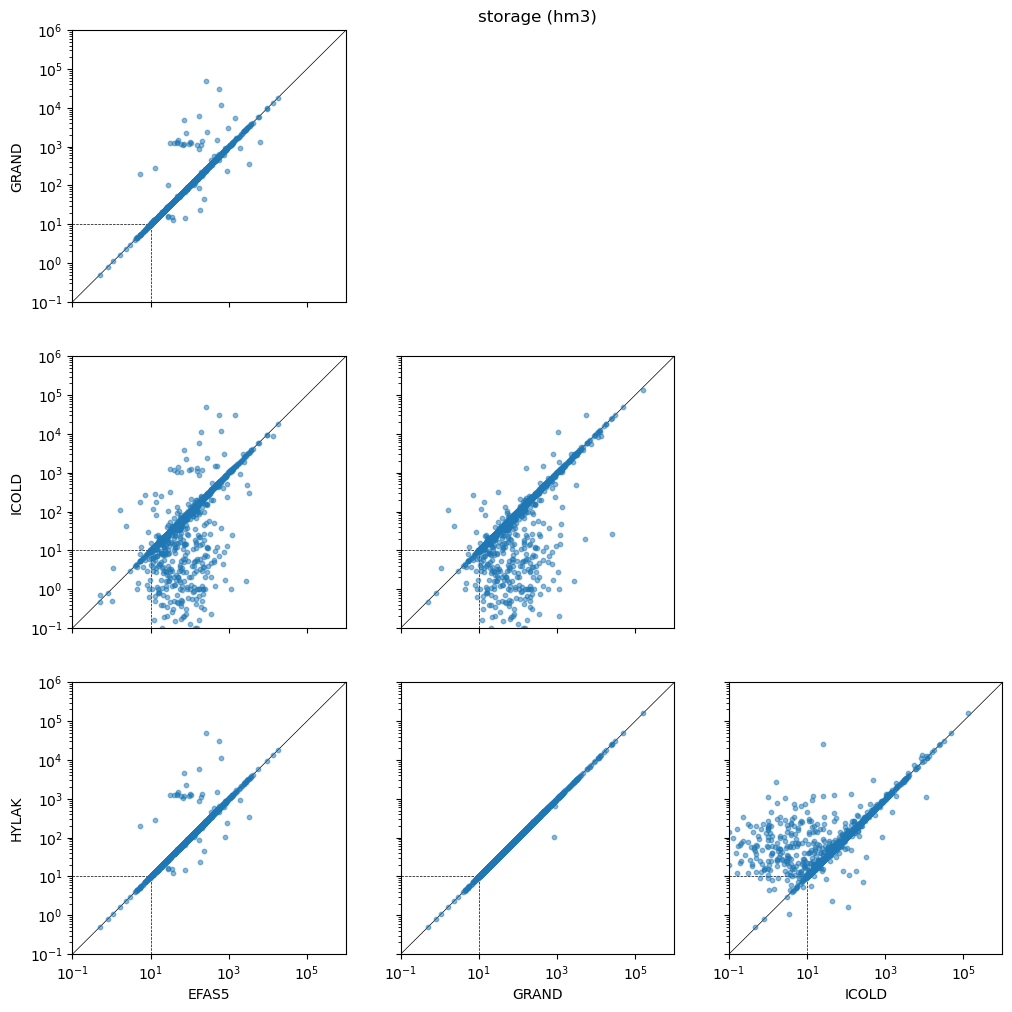

In [12]:
compare_attributes(
    capacity[['EFAS5', 'GRAND', 'ICOLD', 'HYLAK']],
    thr=MIN_VOLUME,
    vmin=1e-1,
    vmax=1e6,
    title='storage (hm3)'
)

In [13]:
# error = 2
# mask_error = (capacity.GRAND < capacity.EFAS5 / error) | (capacity.GRAND > error * capacity.EFAS5)
# print(mask_error.sum())
# capacity[mask_error]

#### Select values

I have manually checked the large discrepancies between EFAS5 and GRanD. In case of discrepancy, I compare with ICOLD and HydroLakes. It seems like GRanD is a more reliable source, so I will use the value from GRanD whenever possible, if not the value from EFAS5.

In [14]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GRAND', 'EFAS5', 'HYLAK', 'ICOLD']:
    missing = capacity.EFAS6.isnull()
    mask = capacity[source].notnull()
    capacity.loc[missing & mask, 'EFAS6'] = capacity.loc[missing & mask, source]
    capacity.loc[missing & mask, 'SOURCE'] = source

# add values to EFAS6
efas6.loc[capacity.index, ['VOL_MCM', 'VOL_SRC']] = capacity[['EFAS6', 'SOURCE']].values

# # storage of reservoirs coming from EFAS5
# efas6[efas6.VOL_SRC == 'EFAS5']['VOL_MCM']

print('{0} reservoirs do not comply with the minimum storage of {1} hm3'.format((efas6.VOL_MCM < MIN_VOLUME).sum(),
                                                                                MIN_VOLUME))

54 reservoirs do not comply with the minimum storage of 10 hm3


### Catchment area

In [15]:
area = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'GRAND', 'ICOLD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# EFAS5
area.loc[efas5.index, 'EFAS5'] = efas5['area']

# # GRanD
# area.loc[efas6.index, 'GRAND'] = efas6.CAP_MCM
mask = grand.ID.notnull()
area.loc[grand.loc[mask, 'ID'], 'GRAND'] = grand.loc[mask, 'CATCH_SKM'].values

# ICOLD
area.loc[efas5.index, 'ICOLD'] = efas5.ICOLD_AREA
mask = icold.ID.notnull()
area.loc[icold.loc[mask, 'ID'], 'ICOLD'] = icold.loc[mask, 'Catch_Area'].values

# HydroLakes
mask = hylak.ID.notnull()
area.loc[hylak.loc[mask, 'ID'], 'HYLAK'] = hylak.loc[mask, 'Wshd_area'].values

#### Comparison

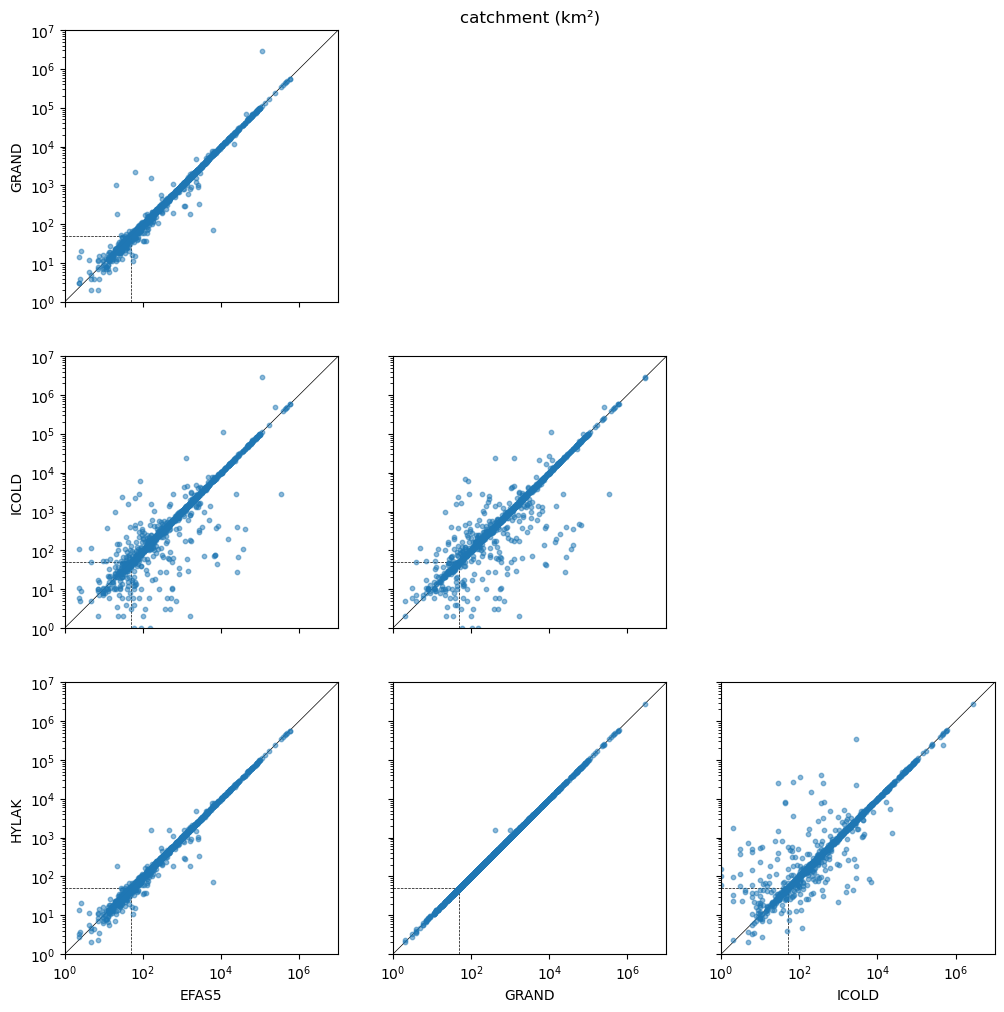

In [18]:
compare_attributes(
    area[['EFAS5', 'GRAND', 'ICOLD', 'HYLAK']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)

#### Select values

Following the procedure applied for the storage capacity, I will use the GRanD value when available.

In [19]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['GRAND', 'EFAS5', 'HYLAK', 'ICOLD']:
    missing = area.EFAS6.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'EFAS6'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source

# add values to EFAS6
efas6.loc[area.index, ['CATCH_SKM', 'CATCH_SRC']] = area[['EFAS6', 'SOURCE']].values

# # storage of reservoirs coming from EFAS5
# efas6[efas6.VOL_SRC == 'EFAS5']['VOL_MCM']

print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((efas6.CATCH_SKM < MIN_AREA).sum(),
                                                                                       MIN_AREA))

235 reservoirs do not comply with the minimum catchment area of 50 km²


## `ncextract`

I run the tool `ncextract` on the EFASv5 long-term run simulation with natural flow, i.e, no reservoirs and no water abstraction. The discharge files resulting from this simulation are in the HPC: `/BGFS/DISASTER/casadje/EFASv5/natural_flow/`.

The discharge time series extracted for the reservoir locations are proxies of the reservoir inflow. From these time series we need to estimate the 100-year return period and normal inflow.

In [22]:
# export CSV needed to run `ncextract`
points = efas6[['LisfloodX', 'LisfloodY']]
points.columns = ['lon', 'lat']
points.to_csv(PATH_EFAS6 / 'ncextract' / 'reservoirs_efas6_new.csv')

## `thresholds`

In [23]:
import sys
sys.path.append('E:/casadje/GitHub/lisflood-utilities/src/')
from lisfloodutilities.thresholds import compute_thresholds_gumbel

In [24]:
PATH_OUT = PATH_EFAS6 / 'tables'
PATH_OUT.mkdir(parents=True, exist_ok=True)

In [25]:
# load discharge timeseries
dis = xr.open_dataset(PATH_EFAS6 / 'ncextract' / 'inflow_ubuntu_new.nc')['dis']

# remove first year to avoid initialization errors
dis = dis.sel(time=slice('1991-01-02', None))

# keep selected reservoirs
dis = dis.sel(ID=efas6.index.tolist())

# # remove IDs with all NaN
# print('IDs with all NaN: {0}'.format(*dis.ID[dis.isnull().all('time')].data))
# dis = dis.dropna(dim='ID', how='all')

### Mean inflow

In [26]:
# mean inflow
efas6['AVG_INFLOW'] = dis.mean('time').to_pandas()
efas6['AVG_INFLOW'].to_csv(PATH_OUT / 'inflow_mean.txt', header=None, sep=' ', float_format='%.1f')

### Degree of regulation

In [46]:
efas6['DOR'] = efas6.VOL_MCM * 1e6 / (efas6.AVG_INFLOW  * 24 * 3600 * 365) 

print('{0} reservoirs do not comply with the minimum degree of regulation {1}'.format((efas6.DOR < MIN_DOR).sum(),
                                                                                       MIN_DOR))

222 reservoirs do not comply with the minimum degree of regulation 0.08


### 100-year return period

In [27]:
# annual maxima
dis_max = dis.groupby('time.year').max(dim='time')#.rename({'year': 'time'})

# inflow return periods
return_periods = [100]
thresholds = compute_thresholds_gumbel(dis_max, return_periods=return_periods, dim='year')

Computing Gumbel coefficients
Computing return periods


In [28]:
# export discharge values
for rp in return_periods:
    var = f'INFLOW_{rp}'
    efas6[var] = thresholds[f'rp_{rp}'].to_pandas()
    efas6[var].to_csv(PATH_OUT / f'{var.lower()}.txt', header=None, sep=' ', float_format='%.1f')

In [29]:
# export parameters
for par in ['mu', 'sigma']:
    thresholds[par].to_pandas().to_csv(PATH_OUT / f'gumbel_{par}.txt', header=None, sep=' ', float_format='%.1f')

In [47]:
# export input shapefile with added attributes
efas6.to_file(PATH_EFAS6 / 'efas6_reservoirs.shp')